# Analysis of the Ethereum Blockchain Arbitrages and Liquidations

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Collection

The data consists of a list of arbitrage transactions, liquidations, block features which are stored on a postgres db.
Additionally, general features of the blockchain e.g. number of protocol usages in the transactions are stored in the db directory.
The arbitrage transactions were collected using calls to multiple Erigon RPC endpoints.

The first collection of data is from block 15200000 to 15500000 or from Jul-23-2022 04:32:35 PM +UTC to Sep-09-2022 01:39:42 AM +UTC.
These blocks are pre-merge blocks. The next collection will analyse the post-merge blocks.

First, we must connect to our database.

In [2]:
# Connect to db
from sqlalchemy import create_engine, text
from db import get_inspect_database_uri

conn = create_engine(get_inspect_database_uri()).connect()

# Arbitrage Analysis

## Data Loading and Cleaning

In [3]:
query = "SELECT * FROM arbitrages WHERE block_number BETWEEN 15200000 AND 15500000"
arb_df = pd.DataFrame(conn.execute(text(query)))
arb_df.set_index('id', inplace=True)
arb_df['timestamp'] = pd.to_datetime(arb_df['timestamp'])
arb_df = arb_df.sort_values('block_number')

In [4]:
arb_df.head()

,transaction_hash,block_number,timestamp,account_address,status,contracts_address,input_tokens_address,input_tokens_amount,output_tokens_address,output_tokens_amount,protocols,gas_price,gas_usage,block_position,profit_amount
id,,,,,,,,,,,,,,,
34,0xd39500706630fb26ea405ce04d7b5884df0866cb1a1c...,15200022,2022-07-23 21:08:45,0xd8c7031da609a6e201e038dd11c97d7f26f1d572,True,"{0xfca9090d2c91e11cc546b0d7e4918c79e0088194,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{5120123648171978000,10837504868.0,7798609065.0}","{0x70e8de73ce538da2beed35d14187f6959a8eca96,0x...","{10837504868.0,7798609065.0,5133779858359948000}",{uniswap_v3},163839,68917,0,1.365621e+16
35,0x63c9c17d97c181b8819783b599a59940a786b5bd2bb6...,15200028,2022-07-23 21:09:18,0xd7c09e006a2891880331b0f6224071c1e890a98a,True,"{0x2c51eaa1bcc7b013c3f1d5985cdcb3c56dc3fbc1,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{240470594654432770,22176822844245777000000}","{0x2d94aa3e47d9d5024503ca8491fce9a2fb4da198,0x...","{22176822844245777000000,248404143686549860}",{uniswap_v2},229745,136481,63,7.933549e+15
37,0xc9c502aec6b07d452ed4ce1e35c20e6cea0cda91e21a...,15200029,2022-07-23 21:09:57,0x5aa3393e361c2eb342408559309b3e873cd876d6,True,"{0xb404057ee4b1d7359ca5a57ac1c020b74c23e56b,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{1906092123352685000,105673083691328340000}","{0x50d1c9771902476076ecfc8b2a83ad6b9355a4c9,0x...","{105673083691328340000,1939547111027948800}","{uniswap_v3,uniswap_v2}",947727,65768,33,3.345499e+16
36,0x2eb09482b29b2d32a240142dee1e7ec6288719c7f049...,15200029,2022-07-23 21:09:57,0xe8c060f8052e07423f71d445277c61ac5138a2e5,True,"{0x06db071bebeb0570a8f3aa0e49238140bedc268f,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{203776686158774270,2011097854535.0,1272233986...","{0x53fd2342b43ecd24aef1535bc3797f509616ce8c,0x...","{2011097854535.0,12722339869926854000000,22747...",{uniswap_v2},474200,37474,37,2.369401e+16
38,0x7acd0000e5e346c66e58aac81c4f48ad6022c6a0184c...,15200034,2022-07-23 21:11:19,0xd8c7031da609a6e201e038dd11c97d7f26f1d572,True,"{0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{6483562585462506000,9898566457.0,120839032289...","{0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x...","{9898566457.0,120839032289753.0,64965197108999...",{uniswap_v3},156765,60038,1,1.295713e+16


In [5]:
arb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114160 entries, 34 to 106593
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   transaction_hash       114160 non-null  object        
 1   block_number           114160 non-null  int64         
 2   timestamp              114160 non-null  datetime64[ns]
 3   account_address        114160 non-null  object        
 4   status                 114160 non-null  bool          
 5   contracts_address      114160 non-null  object        
 6   input_tokens_address   114160 non-null  object        
 7   input_tokens_amount    114160 non-null  object        
 8   output_tokens_address  114160 non-null  object        
 9   output_tokens_amount   114160 non-null  object        
 10  protocols              114160 non-null  object        
 11  gas_price              114160 non-null  int64         
 12  gas_usage              114160 non-null  int

## Status Analysis

Get the success rate of each address and protocol.

In [6]:
def count_features_grouped_by(df: pd.DataFrame, condition: str, _by: [str], features: [str]) -> pd.DataFrame:
    return df.loc[eval(condition)].groupby(by=_by).count().reset_index()[features]

### By Address

Get the success rate of each address

In [7]:
address_success_rate = arb_df.groupby('account_address')['status'].mean()
print('Success rate of each address:')
address_success_rate.head()

Success rate of each address:


account_address
0x0000000000000eb4ec62758aae93400b3e5f7f18    1.000000
0x000000000000660def84e69995117c0176ba446e    0.846154
0x0000000000007f150bd6f54c40a34d7c3d5e9f56    1.000000
0x0000000000036414940324055c43e75f56b7d016    1.000000
0x00000000000970375ff38f05eb9d6db32ae40708    0.666667
Name: status, dtype: float64

### By Protocol
Get the success rate of each address


In [8]:
# Split the protocols column into separate columns for each protocol
protocols_df = arb_df["protocols"].str.replace("[{}]", "", regex=True).str.get_dummies(sep=",")

# Concatenate the status column and the protocol columns
merged_df = pd.concat([arb_df["status"], protocols_df], axis=1)

# Calculate the success rate for each protocol
rates_df = merged_df.mean()
rates_df = rates_df.drop("status")

rates_df

balancer_v1    0.099974
bancor         0.000044
curve          0.006289
uniswap_v2     0.852260
uniswap_v3     0.439813
dtype: float64

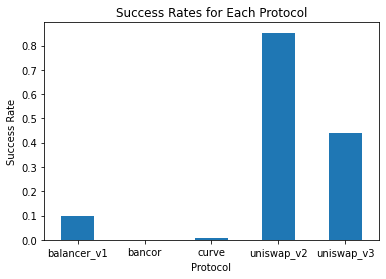

In [9]:
rates_df.plot(kind="bar", rot=0)
plt.title("Success Rates for Each Protocol")
plt.xlabel("Protocol")
plt.ylabel("Success Rate")
plt.show()

## Gas Usage Analysis

### Distribution


### Average gas usage per block
Compare average gas price for arbitrage transactions in each block with the total average gas price of that block.

First, load the blocks data.

In [10]:
query = "SELECT * FROM blocks WHERE block_number BETWEEN 15200000 AND 15500000"
block_df = pd.DataFrame(conn.execute(text(query)))
block_df.head()

,block_number,avg_gas_price,avg_gas_usage
0,15350000,2.721346e+10,147368.451923
1,15350001,2.254700e+10,132315.841629
2,15350002,2.462672e+10,143398.263889
3,15350003,1.947772e+10,193935.637097
4,15350004,2.215424e+10,159431.977011


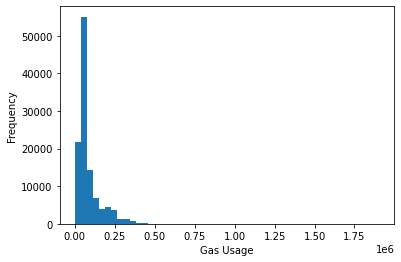

In [11]:
# Gas usage distribution

plt.hist(arb_df['gas_usage'], bins=50)
plt.xlabel('Gas Usage')
plt.ylabel('Frequency')
plt.show()

### Compared with all transactions

In [12]:
avg_gas_per_block = arb_df.groupby('block_number')['gas_usage'].mean()

In [13]:
# merge the average gas usage per block with the blocks_df dataframe
merged_df = pd.merge(block_df, avg_gas_per_block, on='block_number', how='inner')
merged_df.sort_values(by='block_number')

,block_number,avg_gas_price,avg_gas_usage,gas_usage
21,15200022,4.153248e+10,134339.764151,68917.0
22,15200028,2.738264e+10,200588.850000,136481.0
23,15200029,3.027934e+10,159324.673966,51621.0
24,15200034,4.212785e+10,155170.612903,60038.0
25,15200042,3.362009e+10,124875.841837,65111.0
...,...,...,...,...
65184,15499977,1.275421e+10,150213.633094,41032.0
65185,15499983,2.279058e+10,173226.878453,124695.0
65186,15499984,2.380291e+10,138621.292237,86905.0
65187,15499989,2.014510e+10,156501.361204,146233.0


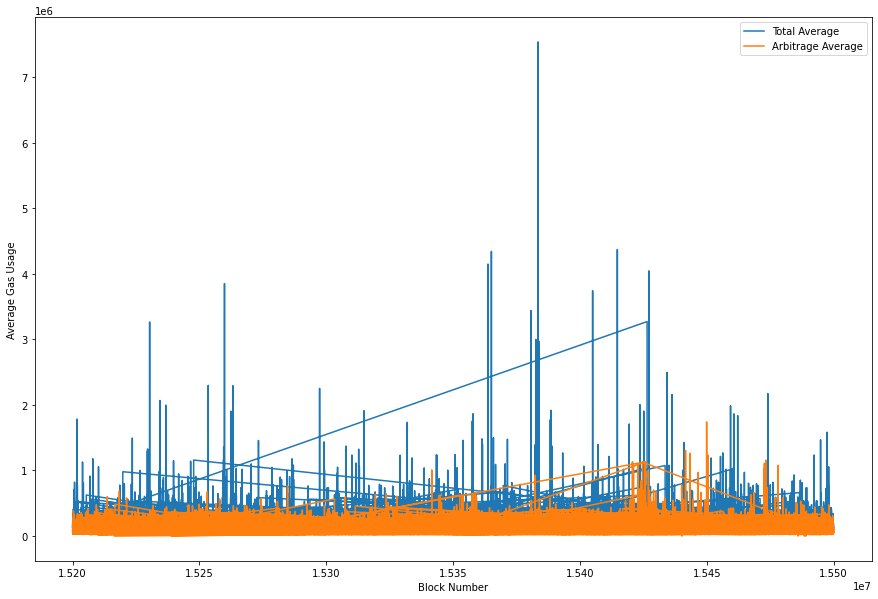

In [14]:
# plot the comparison of average gas usage per block with total average
plt.figure(figsize=(15, 10))
plt.plot(merged_df['block_number'], merged_df['avg_gas_usage'], label='Total Average')
plt.plot(merged_df['block_number'], merged_df['gas_usage'], label='Arbitrage Average')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Usage')
plt.legend()
plt.show()

## Gas Price Analysis

### Distribution

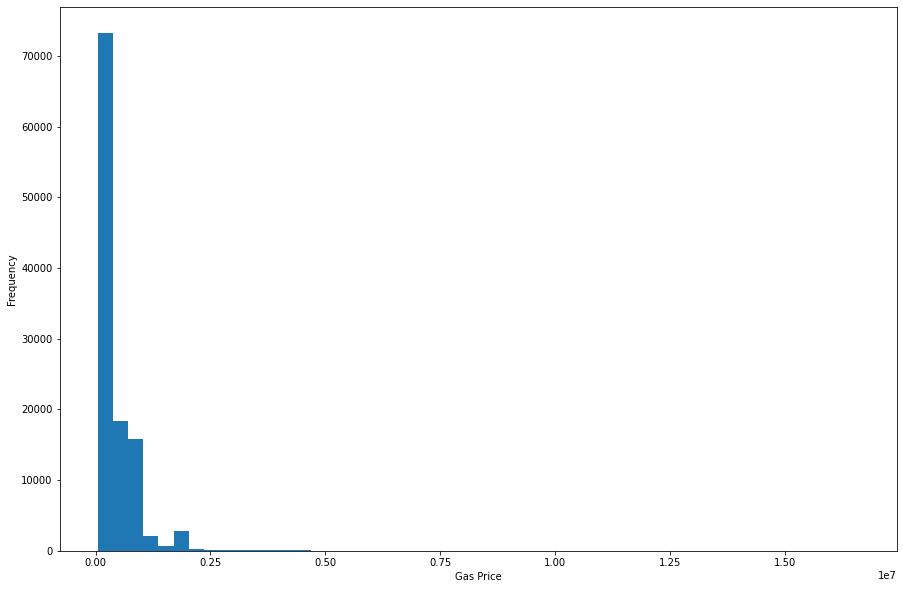

In [15]:
# Gas usage distribution

plt.figure(figsize=(15, 10))
plt.hist(arb_df['gas_price'], bins=50)
plt.xlabel('Gas Price')
plt.ylabel('Frequency')
plt.show()

### Compared with all transactions

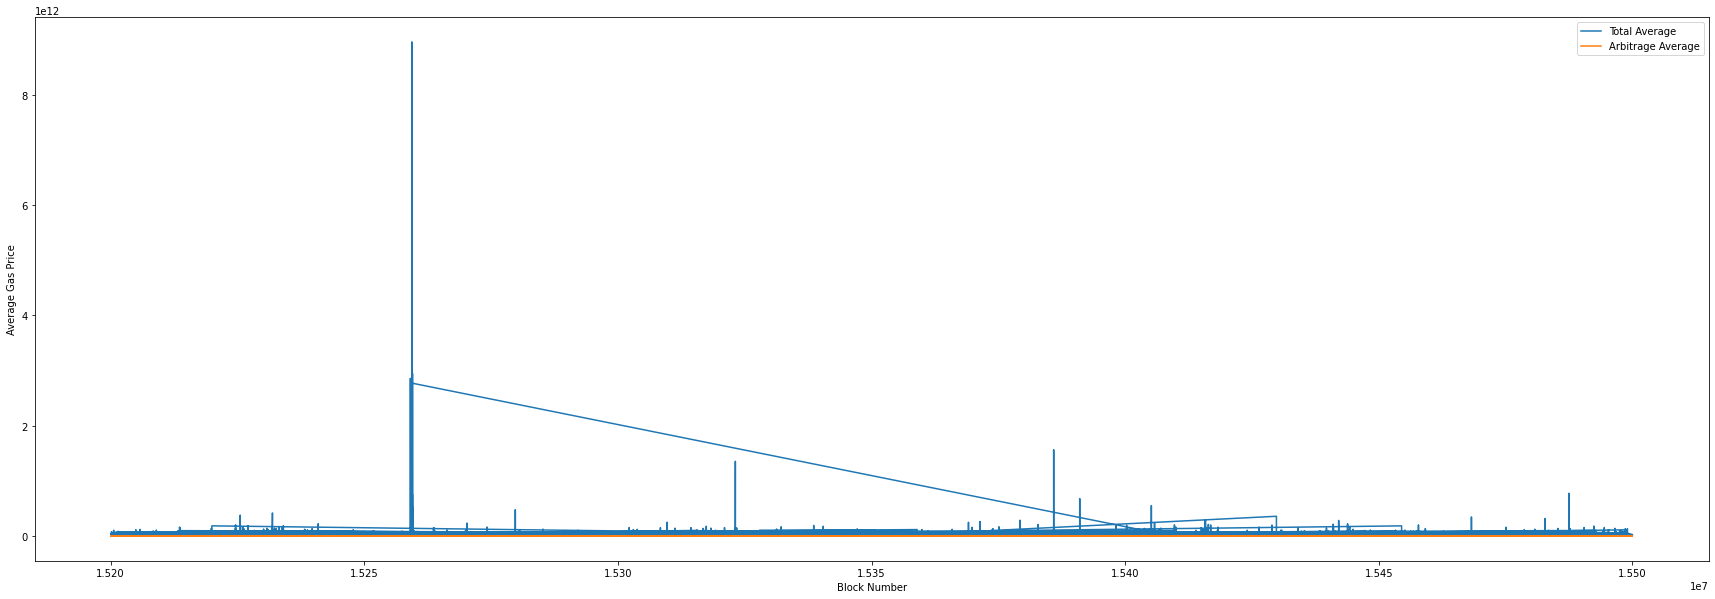

In [16]:
avg_gas_per_block = arb_df.groupby('block_number')['gas_price'].mean()

# merge the average gas price per block with the blocks_df dataframe
merged_df = pd.merge(block_df, avg_gas_per_block, on='block_number', how='inner')
merged_df.sort_values(by='block_number')

# plot the comparison of average gas usage per block with total average
plt.figure(figsize=(30, 10))
plt.plot(merged_df['block_number'], merged_df['avg_gas_price'], label='Total Average')
plt.plot(merged_df['block_number'], merged_df['gas_price'], label='Arbitrage Average')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Price')
plt.legend()
plt.show()

# Analysis of the Tokens

In the first part, we show the most used tokens for profit in arbitrage.
Note that in an arbitrage transaction there might be several tokens involved but in the end the arbitrageur gains profit from a single token (this is the most basic analysis of arbitrage transactions, it's possible that the user gains profit from multiple tokens which occur in more complex arbitrages).

In [ ]:
def _total_profit(_address: str):
    return arb_df.loc[arb_df.account_address == _address, 'profit_amount'].sum()


def _token_use(token_column: str):
    _tokens = arb_df[token_column].apply(lambda lst: list(dict.fromkeys(lst.split(";"))))

    _token_uses = {}
    for row, _cnt in _tokens.value_counts().iteritems():
        for idx in row:
            _token_uses[idx] = _token_uses.get(idx, 0) + _cnt

    return pd.DataFrame(_token_uses.values(), index=_token_uses.keys())


def _get_token_degrees():
    input_tokens_degree = pd.DataFrame(columns=['transaction_hash', 'degree'], dtype='object')
    output_tokens_degree = pd.DataFrame(columns=['transaction_hash', 'degree'], dtype='object')
    output_tokens_degree['transaction_hash'] = arb_df['transaction_hash']
    input_tokens_degree['transaction_hash'] = arb_df['transaction_hash']
    output_tokens_degree['degree'] = arb_df['output_tokens_address'].apply(
        lambda lst: len(list(dict.fromkeys(lst.split(";")))))
    input_tokens_degree['degree'] = arb_df['input_tokens_address'].apply(
        lambda lst: len(list(dict.fromkeys(lst.split(";")))))
    return input_tokens_degree, output_tokens_degree


from tokens.name_tags import get_name_tag


def _get_name_tags(addresses):
    _public_name_tags = {}

    for address in addresses:
        _public_name_tags[address] = get_name_tag(_address=address)

    return _public_name_tags

## Most Used Tokens

In [ ]:
profitable_input_tokens = _token_use('input_tokens_address')
profitable_output_tokens = _token_use('output_tokens_address')

In [ ]:
profitable_input_tokens

In [ ]:
profitable_output_tokens

### Difference between input and output degrees of arbitrage transactions

In [ ]:
any(profitable_output_tokens - profitable_input_tokens != 0)

The input and output degrees of the tokens are equal.

### Transaction Degree Analysis
Now, let's check the degree vvalue of arbitrage transactions

In [ ]:
del profitable_output_tokens

In [ ]:
tokens_degree, _ = _get_token_degrees()
tokens_degree

In [ ]:
tokens_degree.hist('degree')

In [ ]:
# Get the most profitable tokens
# profitable_input_tokens

MIN_PROFITABLE_TXN_CNT = 1000

most_profitable_tokens = profitable_input_tokens.drop(
    labels=profitable_input_tokens[profitable_input_tokens.values < MIN_PROFITABLE_TXN_CNT].index).sort_values(by=[0],
                                                                                                               ascending=False)[
                         :20]

public_name_tags = _get_name_tags(most_profitable_tokens.index)

In [ ]:
def bar(ax, x, y, _rotation=45, _width=0.3):
    ax.bar(x, y, width=_width)
    ax.set_xticks(x)
    ax.set_xticklabels(x, rotation=_rotation)

In [ ]:
from matplotlib.transforms import ScaledTranslation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

bar(ax1, most_profitable_tokens.index.map(public_name_tags), most_profitable_tokens.values.squeeze())
bar(ax2, most_profitable_tokens.index.map(public_name_tags), most_profitable_tokens.values.squeeze())

ax1.set_ylim(most_profitable_tokens.values[0] - 5000, most_profitable_tokens.values[0] + 5000)  # outliers only
ax2.set_ylim(0, most_profitable_tokens.values[1] + 2000)  # most of the data

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .010  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax1.set_title("Most used tokens for arbitrage")
ax2.set_xlabel("Token public name tag")
f.text(0.08, 0.5, 'Number of arbitrages', va='center', rotation='vertical')

# https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label-in-matplotlib
# Create offset transform by 5 points in x direction
dx = -0.2
dy = 0.
offset = ScaledTranslation(dx, dy, f.dpi_scale_trans)

for label in ax2.get_xmajorticklabels():
    label.set_transform(label.get_transform() + offset)

plt.show()

### Tokens Normalization

In [ ]:
most_profitable_tokens

The most used token is WETH. This is because arbitrageurs usually buy an arbitrage asset using ETH and gain the profit by selling them in ETH.
This might be because the WETH-TOKEN pools are more common in the exchanges.
The three latter places belong to stable coins: USDC, USDT and DAI
In the most used tokens we can see a lot of rather lesser known and stable coins: SHIB, FRAX, FunFair etc.
Note that originally we only stored and counted the profit token which is usually WETH. But as mentioned before, the arbitrage opportunity is not a result of instability in WETH, rather in the instability of a certain token which is then seized using the WETH pool.


## Most Active Addresses

In this part we take a look at the most active arbitrageurs i.e. the addresses that have the most arbitrage transactions.
We can use this data along with the most profitable addresses to see if there is any relation between number of txns and profit??

Get the distribution of the number of transactions

In [ ]:
# Get the most arbitrageurs
MIN_ARBITRAGE_TXN_CNT = 2000

arbitrageurs = arb_df['account_address'].value_counts()

most_active_arbitrageurs = arbitrageurs.drop(labels=arbitrageurs[arbitrageurs.values < MIN_ARBITRAGE_TXN_CNT].index)

In [ ]:
f, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

bar(ax1, most_active_arbitrageurs.index, most_active_arbitrageurs.values, _rotation=60, _width=0.4)

ax1.set_title("Most Frequent Arbitrageurs")
ax1.set_xlabel("Arbitrageur Address")

# https://stackoverflow.com/questions/28615887/how-to-move-a-tick-label-in-matplotlib
# Create offset transform by 5 points in x direction
dx = -0.7
dy = 0.
offset = ScaledTranslation(dx, dy, f.dpi_scale_trans)

for label in ax1.get_xmajorticklabels():
    label.set_transform(label.get_transform() + offset)

f.text(0.08, 0.5, 'Number of arbitrages', va='center', rotation='vertical')

plt.show()

In [ ]:
most_active_arbitrageurs

## Active Addresses Analysis

### Distribution

In [ ]:
fig = plt.figure(figsize=(20, 10))
arb_cnt = arbitrageurs.groupby(arbitrageurs).count()[:100]
labels = [str(i) for i in arb_cnt.index]
plt.bar(labels, arb_cnt.values)
plt.xticks(rotation=90)
plt.xlabel("Number of arbitrages")
plt.ylabel("Number of arbitrageurs")
plt.show()

Not much can be interpreted from the above plot, yet.

In [ ]:
# What if we ignore the single transaction arbitrageurs?

fig = plt.figure(figsize=(20, 10))
arb_cnt = arbitrageurs.groupby(arbitrageurs).count()[1:100]
plt.bar(arb_cnt.index, arb_cnt.values)
plt.xlabel("Number of arbitrages")
plt.ylabel("Number of arbitrageurs")
plt.show()

## Ratio of arbitrage transactions
The percentage of transactions that are arbitrage for each address

### Load Accounts data
Get number of transactions of each address

In [ ]:
from datetime import datetime

adr_db_path = "../db/addresses/"
number_of_files = len(os.listdir(adr_db_path))
column_names = ['txn_cnt_' + str(i) for i in range(number_of_files)]
adr_df = pd.DataFrame(columns=['address'], dtype='object')

i = 0
for file_name in os.listdir(adr_db_path):
    print(datetime.now(), file_name)
    temp_adr_df = pd.read_csv(adr_db_path + file_name, names=['address', 'txn_cnt_' + str(i)], index_col=False)
    temp_adr_df = temp_adr_df.groupby(by=['address']).sum()
    adr_df = adr_df.merge(temp_adr_df, how='outer', on='address')
    print(datetime.now(), file_name, 'end')
    i += 1

adr_df.fillna(0)
adr_df['txn_cnt'] = adr_df[column_names].sum(axis=1)
adr_df.drop(columns=column_names, inplace=True)
adr_df

In [ ]:
adr_df[adr_df['txn_cnt_0'] > np.mean(adr_df[adr_df['txn_cnt_0'] > 1])].hist()

# TODO

### Benefit gained through arbitrage per address

# TODO
## Time Analysis of Arbitrage Transactions
### Frequency for the Blockchain

#### Monthly

In [ ]:
month_df = arb_df.groupby([arb_df['time_stamp'].dt.year, arb_df['time_stamp'].dt.month]).count()[
    ['block_number', 'transaction_hash']]
month_df

In [ ]:
month_df.describe()

In [ ]:
del month_df

#### Daily

In [ ]:
day_df = arb_df.groupby([arb_df['time_stamp'].dt.date]).count()[['block_number', 'transaction_hash']]
day_df

In [ ]:
day_df.describe()

In [ ]:
plt.plot(day_df['block_number'])
del day_df
plt.show()

In [ ]:
# Hourly
hour_df = arb_df.groupby([arb_df['time_stamp'].dt.date, arb_df['time_stamp'].dt.hour]).count()[
    ['block_number', 'transaction_hash']]
hour_df

In [ ]:
hour_df.describe()

In [ ]:
hour_list = list(hour_df['block_number'])

grp_val = 24

plt.plot([sum(hour_list[i:i + grp_val]) for i in range(0, len(hour_list), grp_val)])
plt.show()

In [ ]:
del hour_df

In [ ]:
# By Minute
minute_df = \
    arb_df.groupby(
        [arb_df['time_stamp'].dt.date, arb_df['time_stamp'].dt.hour, arb_df['time_stamp'].dt.minute]).count()[
        ['block_number', 'transaction_hash']]
minute_df

In [ ]:
minute_df.describe()

In [ ]:
del minute_df

### Frequency for Each Account

In [ ]:
# Daily Frequency
acc_freq_df = arb_df.loc[arb_df['account_address'].isin(most_active_arbitrageurs.index)].groupby(
    [arb_df['account_address'], arb_df['time_stamp'].dt.date]).count()[['block_number', 'transaction_hash']]
acc_freq_df

In [ ]:
len(acc_freq_df.index.get_level_values(0).unique())

### Frequency for Each Protocol

### Block position

# TODO
## Arbitrage input output degree Analysis

# TODO

## Most used protocols

In [ ]:
protocol_uses = _protocol_use()
protocol_uses

In [ ]:
normalized_protocol_uses = {}

for protocol, cnt in protocol_uses.items():
    normalized_protocol_uses[protocol] = cnt / swp_df.protocol.value_counts()[protocol]

normalized_protocol_uses

In [ ]:
f, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

ax1.bar(protocol_uses.keys(), protocol_uses.values(), width=0.5)
ax1.set_xticklabels(protocol_uses.keys(), rotation=45)
ax1.set_title("Most Used Protocols (Not Normalized)")
ax1.set_xlabel("Protocol")
f.text(0.08, 0.5, 'Number of arbitrages', va='center', rotation='vertical')

plt.show()

In [ ]:
f, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

ax1.bar(normalized_protocol_uses.keys(), normalized_protocol_uses.values(), width=0.5)
ax1.set_xticklabels(normalized_protocol_uses.keys(), rotation=45)
ax1.set_title("Most Used Protocols (Normalized)")
ax1.set_xlabel("Protocol")
f.text(0.08, 0.5, 'Number of arbitrages', va='center', rotation='vertical')

plt.show()

# TODO

## Topological Analysis of Arbitrageur Nodes

# TODO
## Mempool wait time for arbitrage transactions